#  ARMA Prediction with a Kalman filter

In [5]:
import ssm

In [6]:
import jax
import einops
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [7]:
%config InlineBackend.figure_format = "retina"

sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
# plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.rcParams["figure.figsize"] = (7.2, 3.0)

jnp.set_printoptions(linewidth=200)

In [8]:
%load_ext autoreload
%autoreload 2

## The Kalman filter and predictions

In [9]:
@partial(jax.jit, static_argnames=("k",))
def forecast_mean(F, mu, k):
    """
    Following Proposition 2.2 in F.02
    """
    def _step(mu, _):
        mu_next = F @ mu
        return mu_next, mu_next
    steps = jnp.arange(k)
    _, mu_pred = jax.lax.scan(_step, mu, steps)
    return mu_pred


@partial(jax.jit, static_argnames=("k",))
def forecast_cov(F, Sigma, Q, k):
    """
    Following Proposition 2.3 in F.02
    """
    def _step(state, _):
        Sigma_mult, dynamics_carry, F_mult = state

        dynamics_carry = dynamics_carry + F_mult @ Q @ F_mult.T
        F_mult = F @ F_mult        
        Sigma_mult = F @ Sigma_mult @ F.T

        Sigma_pred = Sigma_mult + dynamics_carry
        
        state_next = (Sigma_mult, dynamics_carry, F_mult)
        return state_next, Sigma_pred
    steps = jnp.arange(k)
    dim_state = len(Q)
    state_init = (Sigma, jnp.zeros((dim_state, dim_state)), F)
    _, Sigma_pred = jax.lax.scan(_step, state_init, steps)
    return Sigma_pred

In [10]:
def kf_step(bel, y, H, F, R, Q, n_forecast):
    mu, Sigma = bel

    # Predict
    mu_pred = F @ mu
    Sigma_pred = F @ Sigma @ F.T + Q

    # innovation
    S = H @ Sigma_pred @ H.T + R
    K = jnp.linalg.solve(S, H @ Sigma_pred).T
    err =  y - H @ mu_pred # innovation

    # Update
    mu_update = mu_pred + K @ err
    Sigma_update = Sigma_pred - K @ S @ K.T
    bel_next = (mu_update, Sigma_update)

    out = {
        "mu": mu_update,
        "err": err,
        "yhat": H @ mu_pred,
        "y_corrected": H @ mu_update,
    }

    return bel_next, out

## Defining the ARMA process

In [11]:
key = jax.random.PRNGKey(3141)

In [12]:
ma_n = 10
H_ma = jnp.ones(10) * 1.
H_ar = jnp.ones(3) * jnp.zeros(3).at[0].set(0.8)
H, F, T = ssm.init_arma_components(H_ma=H_ma)
# H, F, T = ssm.init_arma_components(H_ar=H_ar, H_ma=H_ma)
# H, F, T = ssm.init_arma_components(H_ar=H_ar)
dim_state = len(H)
# R = jnp.eye(1) * 1.0 ** 2
R = jnp.eye(1) * 1.0 ** 2

In [13]:
n_steps = 80
n_test = 20
steps = jnp.arange(n_steps)
sample = ssm.sample_ssm(key, F, H, T, R, n_steps + n_test)

test = jax.tree.map(lambda x: x[-n_test:], sample)
sample = jax.tree.map(lambda x: x[:-n_test], sample)

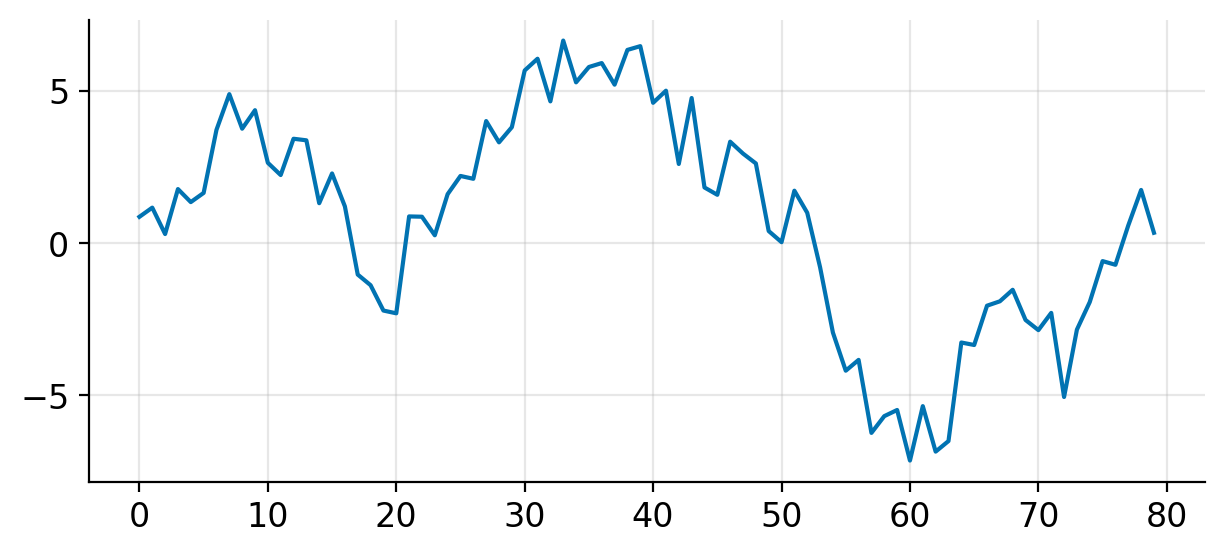

In [14]:
plt.plot(sample["y"])
plt.grid(alpha=0.3)

In [15]:
Q = T @ R @ T.T
n_forecast = 10
_step = partial(kf_step, H=H[None, :], F=F, R=R, Q=Q, n_forecast=n_forecast)
y = sample["y"]

mu_init = jnp.zeros(dim_state)
Sigma_init = jnp.eye(dim_state)
bel_init = (mu_init, Sigma_init)

(mu, Sigma), hist = jax.lax.scan(_step, bel_init, y[:, None])

In [16]:
filter_hist = jnp.einsum("i,ti->t", H, hist["mu"])

In [17]:
jnp.sqrt(jnp.power(hist["err"], 2).mean())

Array(1.3689963, dtype=float32)

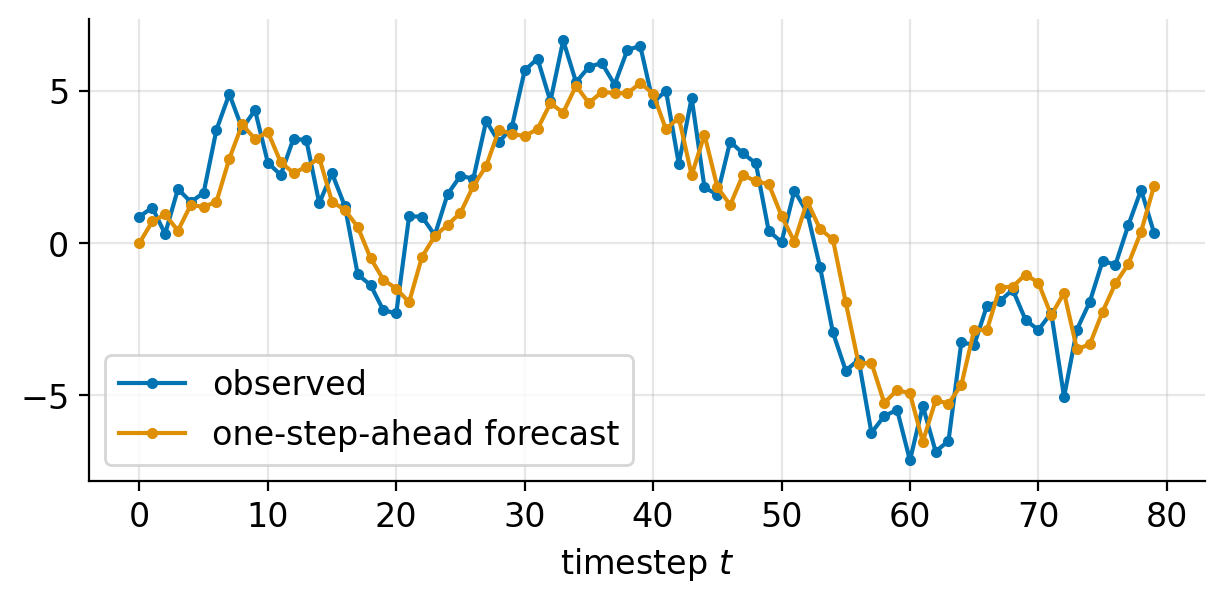

In [18]:
plt.plot(sample["y"], marker="o", markersize=3, label="observed")
plt.plot(hist["yhat"], marker="o", markersize=3, label="one-step-ahead forecast")
plt.legend()
plt.xlabel("timestep $t$")
plt.grid(alpha=0.3)

In [19]:
y = sample["y"]

## Learning and filtering

In [29]:
import chex

In [52]:
@chex.dataclass
class KFState:
    mean: jax.Array
    cov: jax.Array
    dim: int

    @staticmethod
    def init(dim, cov_coeff, cov_latent):
        mean_init = jnp.zeros(2 * dim)
        
        cov_coeff_init = jnp.eye(dim) * cov_coeff
        cov_latent_init = jnp.eye(dim) * cov_latent
        cov_init = jnp.zeros((2 * dim, 2 * dim))
        cov_init = cov_init.at[:dim, :dim].set(cov_coeff_init)
        cov_init = cov_init.at[dim:, dim:].set(cov_latent_init)
        
        return KFState(mean=mean_init, cov=cov_init, dim=dim)

    @property
    def mean_coeff(self):
        return self.mean[:self.dim]

    @property
    def mean_latent(self):
        return self.mean[self.dim:]

In [53]:
state = KFState.init(dim=2, cov_coeff=1, cov_latent=1)

In [57]:
def kf_step(bel: KFState, y, H, F, R, Q):
    mu, Sigma = bel

    # Predict
    mu_pred = F @ mu
    Sigma_pred = F @ Sigma @ F.T + Q

    # innovation
    S = H @ Sigma_pred @ H.T + R
    K = jnp.linalg.solve(S, H @ Sigma_pred).T
    err =  y - (H @ mu_pred - bel.mean_coeff.T @ bel.mean_latent) # innovation

    # Update
    mu_update = mu_pred + K @ err
    Sigma_update = Sigma_pred - K @ S @ K.T
    bel_next = (mu_update, Sigma_update)

    out = {
        "mu": mu_update,
        "err": err,
        "yhat": H @ mu_pred,
        "y_corrected": H @ mu_update,
    }

    return bel_next, out